<a href="https://colab.research.google.com/github/eugenie-kim012/Daily-Log/blob/main/14th_May_2025_Boston_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
# import를 다른걸로 바꿔주고
from sklearn.datasets import fetch_openml
boston = fetch_openml(name='boston')
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)
# 이 부분 두개가 카테고리 데이터로 되어있어서 수치형으로 변환해주세요!
bostonDF['RAD'] = pd.to_numeric(bostonDF['RAD'], errors='coerce')
bostonDF['CHAS'] = pd.to_numeric(bostonDF['CHAS'], errors='coerce')

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()
# NULL 값은 없으며, 모두 float 형임

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


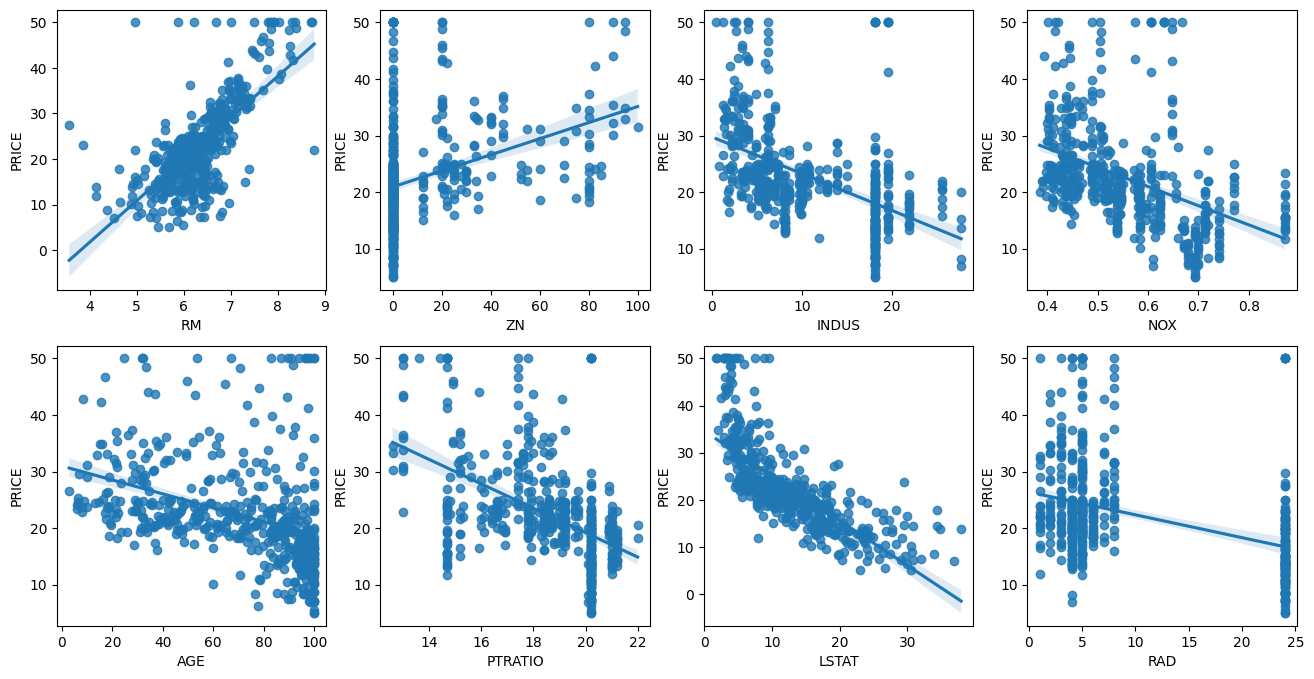

In [5]:
# 2개의 행과 4개의 열을 가진 subplot을 생성합니다. 전체 figure 크기는 (16, 8)입니다.
# axs는 2x4 (즉, 8개)의 subplot axes를 포함하는 2차원 배열입니다.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

# 회귀 분석에 사용할 피처(변수) 이름들을 리스트로 정의합니다.
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']

# enumerate로 피처 리스트를 순회하면서 각 피처의 인덱스(i)와 이름(feature)를 가져옵니다.
for i, feature in enumerate(lm_features):
    row = int(i / 4)        # subplot의 행 위치를 계산 (4개씩 한 줄이므로)
    col = i % 4             # subplot의 열 위치를 계산

    # seaborn의 regplot을 사용해 각 피처(feature)와 주택 가격(PRICE) 사이의 산점도와 회귀선을 그립니다.
    # 각 subplot(axs[row][col])에 그려 넣습니다.
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

# 현재의 figure 객체를 가져옵니다.
fig1 = plt.gcf()

# 현재 figure(fig1)를 TIFF 이미지로 저장합니다.
# 해상도는 300dpi, bbox_inches='tight'는 여백을 최소화해 저장합니다.
fig1.savefig('p322_boston.tif', format='tif', dpi=300, bbox_inches='tight')


# RM 그리고 LSTAT의 PRICE 영향이 가장 두드러지게 나타남

회계 모델 돌리기 전에 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화 하기

# 보스턴 주택 가격의 회귀 모델 만들기

In [6]:
from sklearn.model_selection import train_test_split   # 데이터셋 분할 함수
from sklearn.linear_model import LinearRegression      # 선형 회귀 모델
from sklearn.metrics import mean_squared_error, r2_score  # 평가 지표

# 목표 변수(y)는 'PRICE' 컬럼
y_target = bostonDF['PRICE']

# 입력 변수(X)는 'PRICE' 컬럼을 제외한 나머지 (새로운 DataFrame으로 복사)
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

# 학습용/테스트용 데이터를 70:30 비율로 분리, 시드값은 156으로 고정 (재현 가능성 위해)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 모델 객체 생성
lr = LinearRegression()

# 학습 데이터를 이용하여 모델 학습
lr.fit(X_train, y_train)

# 테스트 데이터를 이용하여 가격 예측 수행
y_preds = lr.predict(X_test)

# 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, y_preds)

# 평균 제곱근 오차(RMSE): 예측값의 오차의 크기를 실제 단위로 환산한 지표
rmse = np.sqrt(mse)

# 결과 출력: MSE와 RMSE
print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))

# 결정 계수(R^2 Score): 1에 가까울수록 성능이 좋은 모델
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))


MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [7]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [8]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

,0
RM,3.4
CHAS,3.0
RAD,0.4
ZN,0.1
INDUS,0.0
B,0.0
TAX,-0.0
AGE,0.0
CRIM,-0.1
LSTAT,-0.6


In [9]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

# 사이킷런은 음수로 만들어줘야 MSE가 낮을 수록 높다는 logic 과 맞음
# 사이킷런 - 교차검증, 여러조각으로 나눈 후 평가/ 학습/ 평균

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


# 다항 회귀와 과(대)적합/ 과소 적합의 이해

In [10]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0,1],[2,3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n',X )

# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 feature:\n', poly_ftr)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 feature:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [11]:
import numpy as np

# 다항식 함수 정의: X는 2차원 배열, 각 행은 [x1, x2]
def polynomial_func(X):
    # y = 1 + 2*x1 + 3*x1^2 + 4*x2^3 형태의 다항식 계산
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    print("X[:, 0] (첫 번째 feature):", X[:, 0])
    print("X[:, 1] (두 번째 feature):", X[:, 1])
    return y

# 0부터 3까지 숫자를 2행 2열 배열로 변환 → 총 2개의 샘플, 각 샘플은 feature 2개
X = np.arange(0, 4).reshape(2, 2)
print('일차 단항식 계수 feature: \n', X)

# 다항식 함수 적용하여 결과 계산
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)


일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
X[:, 0] (첫 번째 feature): [0 2]
X[:, 1] (두 번째 feature): [1 3]
삼차 다항식 결정값: 
 [  5 125]


In [12]:
# 3 차 다항식 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature: \n',poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr,y)
print('Polynomial 회귀 계수\n' , np.round(model.coef_, 2))
print('Polynomial 회귀 Shape :', model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape : (10,)


In [14]:
from sklearn.preprocessing import PolynomialFeatures       # 다항식 특성 변환기
from sklearn.linear_model import LinearRegression          # 선형 회귀 모델
from sklearn.pipeline import Pipeline                      # 전처리 + 모델을 연결하는 파이프라인 도구
import numpy as np

# 다항식 함수 정의: y = 1 + 2*x1 + 3*x1^2 + 4*x2^3
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3             # 다항식 계산
    return y

# Pipeline으로 다항식 변환 + 선형 회귀를 연결
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),                # x1, x2를 최대 3차 다항식 항들로 확장
    ('linear', LinearRegression())                         # 확장된 feature로 선형 회귀 수행
])

X = np.arange(4).reshape(2,2)                               # X: 0~3까지 숫자를 2행 2열로 구성 → [[0,1],[2,3]]
y = polynomial_func(X)                                     # 다항식 함수로 타깃 y 계산 → [5, 125]

model = model.fit(X, y)                                    # Pipeline 전체 학습: (1) 다항식 변환 → (2) 선형 회귀 모델 학습

# 학습된 선형 회귀 모델의 회귀 계수 출력 (소수점 둘째 자리까지 반올림)
print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))


Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환.
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터입니다.
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y 값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값입니다.
y = true_fun(X) + np.random.randn(n_samples) * 0.1

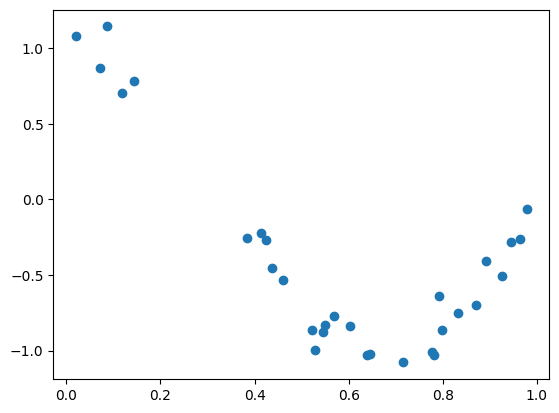

In [16]:
plt.scatter(X, y)



Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE 는 0.4077 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE 는 0.0432 입니다.

Degree 15 회귀 계수는 [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08] 입니다.
Degree 15 MSE 는 181238256.5642 입니다.


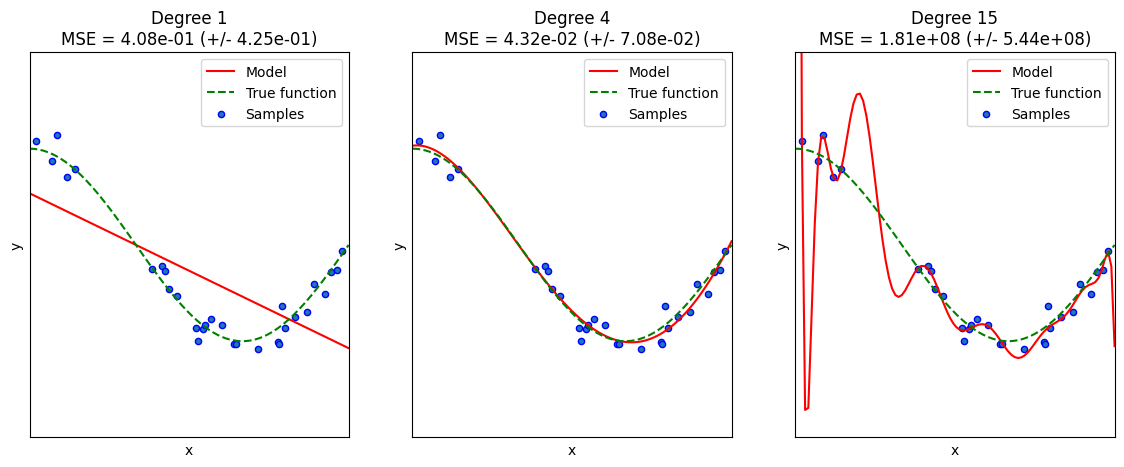

In [17]:
plt.figure(figsize=(14, 5))            # 전체 그래프 크기 설정
degrees = [1, 4, 15]                   # 비교할 다항식 차수

# 각 차수에 대해 반복
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)  # 1행 3열 subplot 중 i+1번째
    plt.setp(ax, xticks=(), yticks=())       # x/y 축 눈금 제거로 깔끔하게

    # Pipeline 구성: 다항 특성 생성 + 선형 회귀
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression)
    ])

    # 모델 학습 (X는 reshape 필요: (n_samples, 1))
    pipeline.fit(X.reshape(-1, 1), y)

    # 교차 검증 (CV=10): 모델 일반화 성능 확인
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y,
                             scoring="neg_mean_squared_error", cv=10)

    # 회귀 계수 확인
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients, 2)))
    print('Degree {0} MSE 는 {1:.4f} 입니다.'.format(degrees[i], -1*np.mean(scores)))

    # 예측 곡선 그리기 위한 테스트 X (100개로 균등 분할)
    X_test = np.linspace(0, 1, 100)
    y_pred = pipeline.predict(X_test[:, np.newaxis])  # 모델 예측 수행

    # 예측 선
    plt.plot(X_test, y_pred, label="Model", color='red')
    # 실제 함수 (진짜 정답)
    plt.plot(X_test, true_fun(X_test), '--', label="True function", color='green')
    # 학습 데이터 점
    plt.scatter(X, y, edgecolor='blue', s=20, label="Samples")

    # 시각화 요소 설정
    plt.xlabel("x"); plt.ylabel("y")
    plt.xlim((0, 1)); plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e} (+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))

plt.show()

| 기능                     | 설명                         |
| ---------------------- | -------------------------- |
| `degrees = [1, 4, 15]` | 다항식의 차수를 바꾸며 모델 성능 비교      |
| `Pipeline`             | 다항 특성 생성 + 선형 회귀를 깔끔하게 연결  |
| `cross_val_score`      | 모델의 평균 MSE(음수값)로 일반화 능력 평가 |
| `subplot + plot`       | 각 차수별 회귀 결과를 시각적으로 비교      |
| `true_fun`             | 모델이 근사해야 할 "진짜 곡선" 정의      |


# Regularized Linear Model - Ridge Regression

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge                    # 릿지 회귀 모델
from sklearn.model_selection import cross_val_score       # 교차 검증 도구
from sklearn.datasets import fetch_openml                 # 외부 데이터셋 로드

# Boston Housing 데이터셋 로드 (주의: fetch_openml은 인터넷 연결 필요)
boston = fetch_openml(name='boston', version=1, as_frame=True)

# feature들을 DataFrame으로 변환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

# 🔄 'RAD', 'CHAS'가 object 타입일 수 있으므로 수치형으로 강제 변환 (coerce: 실패 시 NaN)
bostonDF['RAD'] = pd.to_numeric(bostonDF['RAD'], errors='coerce')
bostonDF['CHAS'] = pd.to_numeric(bostonDF['CHAS'], errors='coerce')

# target 데이터를 PRICE 컬럼으로 추가
bostonDF['PRICE'] = boston.target

# 피처(X), 타겟(y) 분리
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

# 릿지 회귀 모델 생성 (규제 강도 alpha=10)
ridge = Ridge(alpha=10)

# 5-Fold 교차 검증으로 MSE 계산 (음수로 반환됨 → 음수 제거 후 sqrt)
neg_mse_scores = cross_val_score(ridge, X_data, y_target,
                                 scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)               # RMSE 계산
avg_rmse = np.mean(rmse_scores)                          # 평균 RMSE 계산

# 결과 출력
print('5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print('5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 3))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))


5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
5 folds 의 평균 RMSE : 5.518


# alpha값을 0 , 0.1 , 1 , 10 , 100 으로 변경하면서 RMSE 측정

In [21]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


# 각 alpha에 따른 회귀 계수 값을 시각화. 각 alpha값 별로 plt.subplots로 맷플롯립 축 생성

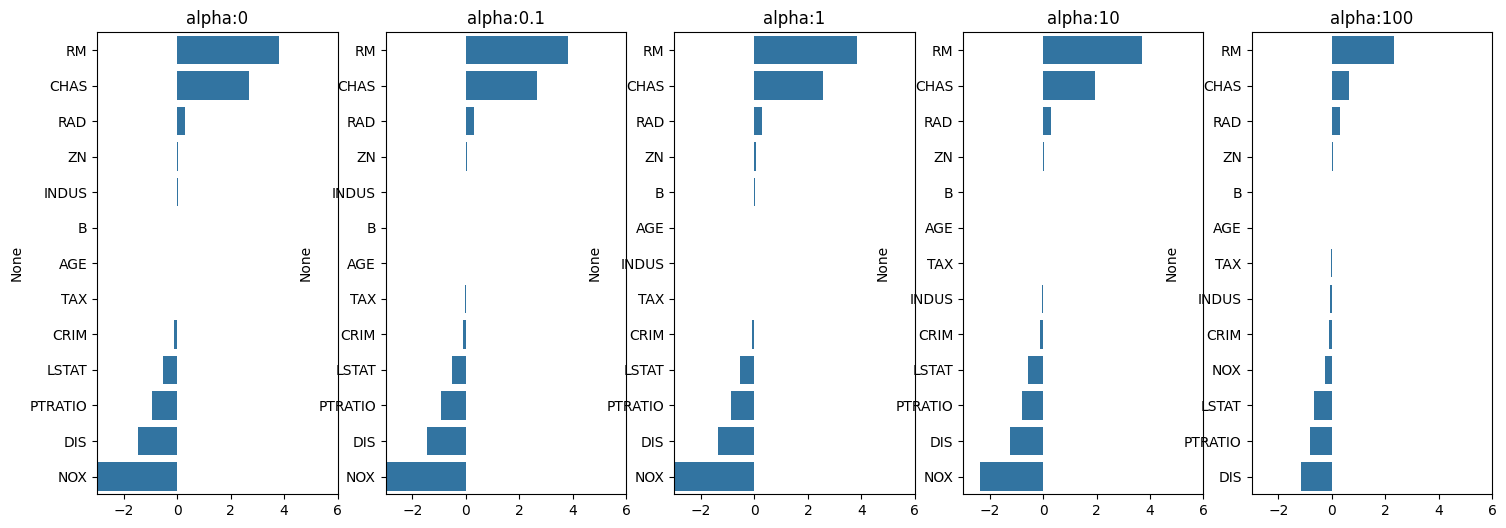

In [22]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [23]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


 | 계수 변화      | 의미               | 장점            | 단점                 |
| ---------- | ---------------- | ------------- | ------------------ |
| **작아짐**    | 변수의 영향력이 줄거나 무시됨 | 과적합 방지, 안정성 ↑ | 성능이 떨어질 수도 있음      |
| **크고 다양함** | 변수마다 영향력이 뚜렷     | 더 많은 설명력      | 과적합 가능성 ↑, 불안정한 계수 |


🤔 그럼 어떤 alpha가 좋은 걸까?
🔥 **답은 “회귀 계수가 작다고 무조건 좋은 게 아니라, 일반화 성능(RMSE 등)이 가장 좋은 알파를 선택해야 한다”**입니다.

✔️ 선택 기준은 분석가의 전략에 따라 아래 중 하나:
예측 정확도가 우선:

cross_val_score()로 각 alpha에 대해 RMSE 계산 후 RMSE가 최소인 alpha 선택

해석력과 단순함이 우선:

회귀 계수가 적고, 영향력 있는 feature만 명확히 남는 더 큰 alpha 선택

밸런스 추구:

예측력과 해석력 사이에서 적절한 alpha를 선택 (ex. GridSearchCV로 튜닝)

✅ 추천 흐름
위 코드로 계수 시각화 → 어떤 피처가 줄어드는지 확인

각 alpha에 대해 cross_val_score()로 RMSE 측정

RMSE 최소 or 해석력 고려하여 최적 alpha 선택

# 라쏘 회귀

In [25]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# 다양한 선형 회귀 모델을 alpha 값별로 평가하고, 평균 RMSE와 회귀 계수들을 반환하는 함수
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):

    coeff_df = pd.DataFrame()  # alpha별 회귀 계수를 저장할 DataFrame

    if verbose:
        print('#######', model_name, '#######')

    for param in params:
        # 모델 이름에 따라 Ridge, Lasso, ElasticNet 인스턴스를 생성
        if model_name == 'Ridge':
            model = Ridge(alpha=param)
        elif model_name == 'Lasso':
            model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=param, l1_ratio=0.7)

        # 교차 검증을 통한 MSE 계산 (neg_mean_squared_error → 양수로 변환 후 sqrt)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                         scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))  # 평균 RMSE 계산

        if verbose:
            print(f'alpha {param}일 때 5 폴드 세트의 평균 RMSE: {avg_rmse:.3f}')

        # cross_val_score는 회귀 계수를 반환하지 않으므로, 다시 전체 데이터로 학습
        model.fit(X_data_n, y_target_n)

        if return_coeff:
            # 회귀 계수를 Series로 변환하여 DataFrame에 추가
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:' + str(param)
            coeff_df[colname] = coeff

    return coeff_df  # 최종적으로 회귀 계수 테이블 반환


In [26]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [27]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


# 엘라스틱넷 회귀

In [28]:

# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [29]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


# 선형 회귀 모델을 위한 데이터 변환
1. standardscale 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 minmaxscaler 클래스를 이용해 최솟값이 0이고 최댓값이 1인 값으로 정규화를 수행

2. 스케일링/ 정규화를 수행한 데이터 세트에 다시 사항 특성을 적요하여 변환 - 보통 1번 방법을 통해 예측 성능에 향상이 없었을 경우 채탯

3. 원래 값에 log함수를 적용하여 보다 정규 분포에 가까운 형태로 값을 분포 - 로그 변환 (log transformation)


In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,
                                         include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [31]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
(506, 13) (506, 13)

## 변환 유형:Log, Polynomial Degree:None


# 로지스틱 회귀

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

# 예측 수행, 정확도와 ROC - AUC 구하기

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression() # solver='lbfgs'
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds),
                                                 roc_auc_score(y_test , lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


# 최적화

In [35]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
# 여러개의 solver값 별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver,
                                                                  accuracy_score(y_test, lr_preds),
                                                                  roc_auc_score(y_test , lr_preds_proba)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.995
solver:liblinear, accuracy: 0.982, roc_auc:0.995
solver:newton-cg, accuracy: 0.977, roc_auc:0.995
solver:sag, accuracy: 0.982, roc_auc:0.995
solver:saga, accuracy: 0.982, roc_auc:0.995


Logsitic regression 클래스의 주요 파라미터 - penalty, C

* panalty - regulation의 유형을 설정하고, l2로 설정 시 l2규제를, l1로 설정시 l1 규제를 적용받음. 기본은 l2.
* C - 1/alpha, C가 작을수록 규제 강도가 큼

* L1, L2 규제의 경우 solver설정에 따라 영향을 받음. liblinear, saga의 경우 l1, l2 규제가 모두 가능하지만 lbgfs, newton-cg, sag의 경우 l2 규제만 가능함.

In [36]:
from sklearn.model_selection import GridSearchCV

params={'solver':['liblinear', 'lbfgs'],
        'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

# 회귀 트리

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  #사이킷런 1.2 부터는 보스턴 주택가격 데이터가 없어진다는 warning 메시지 출력 제거

# import를 다른걸로 바꿔주고
from sklearn.datasets import fetch_openml
boston = fetch_openml(name='boston')
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)
# 이 부분 두개가 카테고리 데이터로 되어있어서 수치형으로 변환해주세요!
bostonDF['RAD'] = pd.to_numeric(bostonDF['RAD'], errors='coerce')
bostonDF['CHAS'] = pd.to_numeric(bostonDF['CHAS'], errors='coerce')
# PRICE(집값) 컬럼을 데이터프레임에 추가
bostonDF['PRICE'] = boston.target

# 타깃 값(y) 설정
y_target = bostonDF['PRICE']

# PRICE를 제외한 나머지 피처(X)만 추출
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

# 랜덤 포레스트 회귀 모델 생성 (트리 1000개, 랜덤 시드 고정)
rf = RandomForestRegressor(random_state=0, n_estimators=1000)

# 5-Fold 교차검증으로 음수 MSE(Negative Mean Squared Error) 점수 계산
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv=5)

# 음수 MSE를 양수로 바꾼 뒤 제곱근을 취해 RMSE로 변환
rmse_scores = np.sqrt(-1 * neg_mse_scores)

# 각 Fold의 RMSE 평균값 계산
avg_rmse = np.mean(rmse_scores)


print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


모델이 있을 때 이런 식으로 정리하라는 코드

In [43]:
def get_model_cv_prediction(model, X_data, y_target):
    # 5-Fold 교차검증으로 음수 MSE 점수 계산
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)

    # 음수 MSE를 양수로 바꾼 뒤 제곱근을 취해 RMSE로 변환
    rmse_scores = np.sqrt(-1 * neg_mse_scores)

    # RMSE 평균값 계산
    avg_rmse = np.mean(rmse_scores)

    # 모델 이름 출력 (클래스 이름 자동 추출)
    print('##### ', model.__class__.__name__, ' #####')

    # 평균 RMSE 출력
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))


In [ ]:
모델 주어주고 예측하라는 코드

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

<Axes: xlabel='None', ylabel='None'>

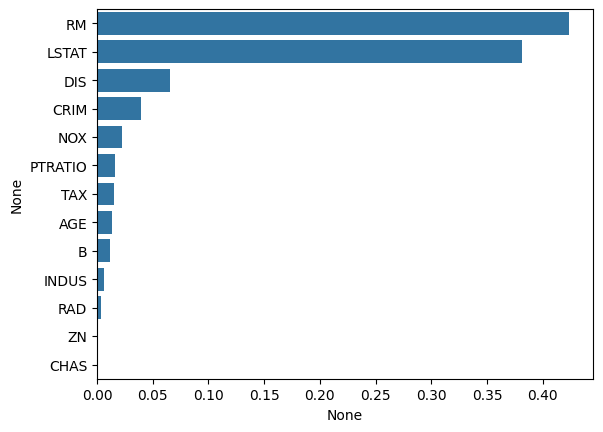

In [47]:
import seaborn as sns              # 시각화 라이브러리
%matplotlib inline
# 주피터/코랩에서 그래프 바로 출력되도록 설정

from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 생성 (트리 1000개 사용)
rf_reg = RandomForestRegressor(n_estimators=1000)

# 모델 학습 (입력 피처 X_data와 타겟값 y_target 사용)
rf_reg.fit(X_data, y_target)

# 각 피처의 중요도 추출 (값이 클수록 해당 피처가 예측에 더 영향을 많이 줌)
feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)

# 중요도가 큰 순서대로 정렬
feature_series = feature_series.sort_values(ascending=False)

# Seaborn barplot을 이용해 중요도 시각화
sns.barplot(x=feature_series, y=feature_series.index)


(100, 2)


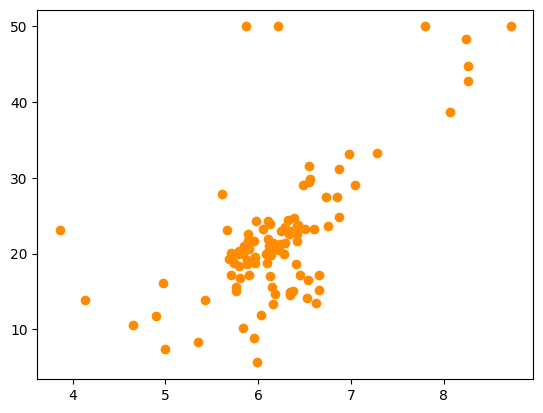

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM , bostonDF_sample.PRICE,c="darkorange")

| 표현               | 의미                        |
| ---------------- | ------------------------- |
| `reshape(-1, 1)` | 열 1개짜리 2차원 배열로 변환         |
| `reshape(1, -1)` | 행 1개짜리 2차원 배열로 변환 (가로 벡터) |


In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 선형 회귀 모델과 결정 트리 회귀 모델 생성 (트리 깊이: 2, 7)
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 테스트 구간 정의: 4.5 ~ 8.5 사이의 값을 0.04 간격으로 생성 (100개 포인트)
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 입력 변수는 RM(평균 방 개수), 타겟 변수는 PRICE(집값)
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 모델 학습
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

# 테스트 구간에 대한 예측 수행
pred_lr = lr_reg.predict(X_test)    # 선형 회귀
pred_rf2 = rf_reg2.predict(X_test)  # 결정 트리 (깊이 2)
pred_rf7 = rf_reg7.predict(X_test)  # 결정 트리 (깊이 7)


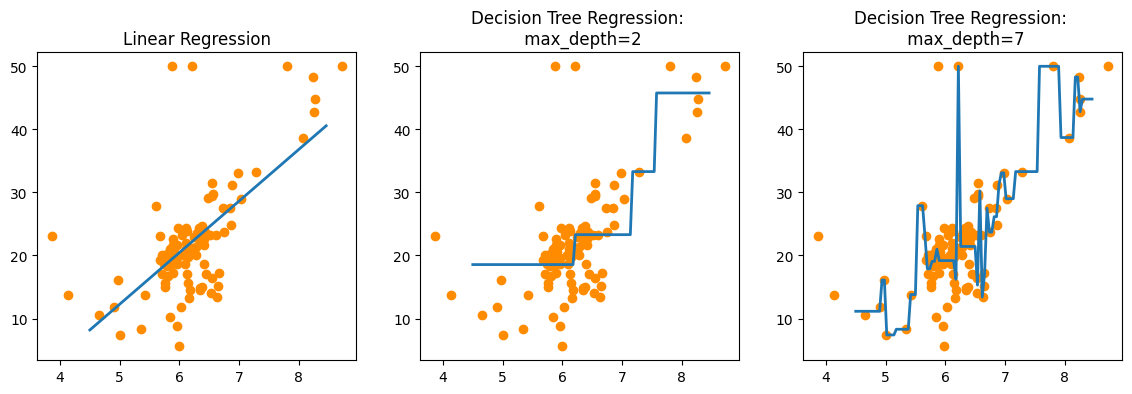

In [51]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. 모델 정의
lr_reg = LinearRegression()
dt_reg2 = DecisionTreeRegressor(max_depth=2)
dt_reg7 = DecisionTreeRegressor(max_depth=7)

# 2. 학습 데이터 (방 개수 RM → 가격 PRICE)
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 3. 모델 학습
lr_reg.fit(X_feature, y_target)
dt_reg2.fit(X_feature, y_target)
dt_reg7.fit(X_feature, y_target)

# 4. RMSE 계산 함수
def get_rmse(model, X, y_true):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return round(rmse, 3)

# 5. 모델별 RMSE 계산
rmse_lr = get_rmse(lr_reg, X_feature, y_target)
rmse_dt2 = get_rmse(dt_reg2, X_feature, y_target)
rmse_dt7 = get_rmse(dt_reg7, X_feature, y_target)

# 6. 결과 출력
print("📊 모델별 RMSE 비교 (훈련 데이터 기준):")
print(f"Linear Regression        : {rmse_lr}")
print(f"Decision Tree (depth=2)  : {rmse_dt2}")
print(f"Decision Tree (depth=7)  : {rmse_dt7}")


📊 모델별 RMSE 비교 (훈련 데이터 기준):
Linear Regression        : 6.817
Decision Tree (depth=2)  : 6.36
Decision Tree (depth=7)  : 2.891
